In [ ]:
# default_exp overlap.swap

In [ ]:
#export 
import numpy as np
from fisherman.utils import sym_from_triu

from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.circuit import ParameterExpression
from qiskit.providers import Backend, BaseBackend
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.opflow import CircuitStateFn, CircuitOp

from collections.abc import Iterable
from typing import Optional, Union, Dict, List, Iterable

# Swap test
> Functionalities to compute the overlap between states through a swap test.

In [ ]:
#export
def swap_test_overlap(
    state0: Union[QuantumCircuit, CircuitStateFn], 
    state1: Optional[Union[QuantumCircuit, CircuitStateFn, Iterable[Union[QuantumCircuit, CircuitStateFn]]]] = None, 
    param_dict: Optional[Dict[ParameterExpression, List[float]]] = None,
    backend: Optional[Union[Backend, QuantumInstance]] = None
) -> np.ndarray:
    """Returns overlap between states using swap test."""
    
    if state1 is not None and param_dict is not None: 
        raise ValueError(
            "swap_test_overlap only accepts one optional input "
            "either `state1` or `param_dict`."
                        )
        
    backend = BasicAer.get_backend('qasm_simulator') if backend is None else backend
    qi = QuantumInstance(backend) if isinstance(backend, Backend) else backend
    if qi.is_statevector:
        raise ValueError("swap_test_overlap does not suport statevector simulator yet.")
        
    if isinstance(state0, QuantumCircuit): 
        state0 = CircuitStateFn(state0)
    
    if state1 is not None:
        if not isinstance(state1, Iterable):
            state1 = [state1]
        state1 = [CircuitStateFn(s) if isinstance(s, QuantumCircuit) else s for s in state1]
        
    n_qubits = state0.num_qubits
    swap_op = _swap_test_operator(n_qubits)
    ancilla = CircuitStateFn(QuantumCircuit(1))
    
    def _swap_circuit(s0, s1):
        circuit = (swap_op @ (s1 ^ s0 ^ ancilla)).primitive
        circuit.add_register(ClassicalRegister(1))
        circuit.measure(0, 0)
        return circuit
    
    if state1 is not None:
        circuits = [_swap_circuit(state0, s) for s in state1]
    elif param_dict is not None:
        states = state0.bind_parameters(param_dict)
        circuits = [_swap_circuit(s_i, s_j)
                    for i, s_i in enumerate(states) for s_j in states[i:]]
    else:
        circuits = [_swap_circuit(state0, state0)]
        
    counts = qi.execute(circuits).get_counts()
    if not isinstance(counts, list): 
        counts = [counts]
        
    p0 = [c.get('0', 0)/sum(c.values()) for c in counts]
    overlaps = 2*np.array(p0) - 1
    
    return overlaps.squeeze() if param_dict is None else sym_from_triu(overlaps, len(states))
     
def _swap_test_operator(n_qubits):
    swap_qc = QuantumCircuit(2*n_qubits+1)
    swap_qc.h(0)
    for q in range(n_qubits):
        swap_qc.cswap(0, q + 1, q + 1 + n_qubits)
    swap_qc.h(0)
    return CircuitOp(swap_qc)

In [ ]:
#hide
from qiskit.circuit import Parameter

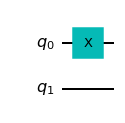

In [ ]:
qc0 = QuantumCircuit(2)
qc0.x(0)
qc0.draw('mpl')

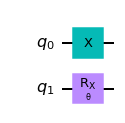

In [ ]:
theta0 = Parameter('θ')
qc1 = QuantumCircuit(2)
qc1.x(0)
qc1.rx(theta0, 1)
qc1.draw('mpl')

In [ ]:
state0 = CircuitStateFn(qc0)
purity = swap_test_overlap(state0)
purity

array([1.])

In [ ]:
theta_values = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
param_dict = {theta0: theta_values}

In [ ]:
state0 = CircuitStateFn(qc0)
state1 = CircuitStateFn(qc1).bind_parameters(param_dict)
overlaps = swap_test_overlap(state0, state1)
overlaps

array([ 1.        ,  0.47851562, -0.0078125 ,  0.44140625,  1.        ])

In [ ]:
param_state = CircuitStateFn(qc1)
overlaps = swap_test_overlap(param_state, param_dict=param_dict)
overlaps

array([[ 1.        ,  0.49609375,  0.0078125 ,  0.50195312,  1.        ],
       [ 0.49609375,  1.        ,  0.48242188,  0.03320312,  0.51171875],
       [ 0.0078125 ,  0.48242188,  1.        ,  0.50585938, -0.00976562],
       [ 0.50195312,  0.03320312,  0.50585938,  1.        ,  0.51171875],
       [ 1.        ,  0.51171875, -0.00976562,  0.51171875,  1.        ]])

In [ ]:
overlaps.diagonal()

array([1., 1., 1., 1., 1.])

In [ ]:
from qiskit.providers.aer import QasmSimulator

In [ ]:
from qiskit.test.mock import FakeVigo

In [ ]:
test_sim = QasmSimulator.from_backend(FakeVigo())
qi_test = QuantumInstance(test_sim)

In [ ]:
qi_test.backend

QasmSimulator('qasm_simulator(fake_vigo)',
              noise_model=<NoiseModel on ['sx', 'cx', 'id', 'x', 'measure']>))

In [ ]:
test_sim.options.noise_model

<NoiseModel on ['sx', 'cx', 'id', 'x', 'measure']>

In [ ]:
backend = QasmSimulator()
o = swap_test_overlap(param_state, param_dict=param_dict, backend=qi_test)
o

array([[0.66210938, 0.36328125, 0.01953125, 0.3359375 , 0.71875   ],
       [0.36328125, 0.71289062, 0.35351562, 0.08203125, 0.40039062],
       [0.01953125, 0.35351562, 0.69335938, 0.375     , 0.0546875 ],
       [0.3359375 , 0.08203125, 0.375     , 0.68359375, 0.328125  ],
       [0.71875   , 0.40039062, 0.0546875 , 0.328125  , 0.66796875]])

In [ ]:
np.round(o, 3)

array([[ 1.   ,  0.484,  0.008,  0.533,  1.   ],
       [ 0.484,  1.   ,  0.527,  0.008,  0.508],
       [ 0.008,  0.527,  1.   ,  0.531, -0.033],
       [ 0.533,  0.008,  0.531,  1.   ,  0.506],
       [ 1.   ,  0.508, -0.033,  0.506,  1.   ]])

In [ ]:
from qiskit.opflow import StateFn